In [11]:

import sys  
sys.path.insert(0, r"C:\\Users\jorge\\Documents\\Projects Jorge C\\DRUIDA PROJECT\\POC\\druida_V01\\src\\")

import os

from __future__ import print_function
#from Utilities.SaveAnimation import Video



from druida import Stack
from druida import setup

from druida.DataManager import datamanager
from druidaHFSS.modules import tools
from druida.tools import utils

import random
import numpy as np
import pandas as pd
from numpy.linalg import norm
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torcheval.metrics import BinaryAccuracy




import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox
import matplotlib.image as image

from IPython.display import HTML

from glob import glob

import argparse





In [12]:
parser = argparse.ArgumentParser()

parser.add_argument("run_name",type=str)
parser.add_argument("epochs",type=int)
parser.add_argument("batch_size",type=int)
parser.add_argument("workers",type=int)
parser.add_argument("gpu_number",type=int)
parser.add_argument("device",type=str)
parser.add_argument("learning_rate",type=float)
parser.add_argument("condition_len",type=float) #This defines the length of our conditioning vector
parser.add_argument("metricType",type=float) #This defines the length of our conditioning vector
parser.add_argument("patch_size",type=int)

parser.run_name = "Predictor Training"
parser.epochs = 20
parser.batch_size = 10
parser.workers=0
parser.gpu_number=0
parser.image_size = 512
parser.dataset_path = os.path.normpath('/content/drive/MyDrive/Training_Data/Training_lite/')
parser.device = "cpu"
parser.learning_rate = 1e-4
parser.condition_len = 10
parser.metricType='AbsorbanceTM' #this is to be modified when training for different metrics.
parser.patch_size=16

metricType=['AbsorbanceTM','AbsorbanceTE' ]

categories=["box", "circle", "cross"]

model_kwargs={
        "batch_size":parser.batch_size,
        "embed_dim":  3 * (parser.patch_size)**2 ,
        "hidden_dim":  2*(3 * (parser.patch_size)**2),
        "num_heads": 8,
        "num_layers": 4,
        "patch_size": parser.patch_size,
        "num_channels": 3,
        "num_patches": (parser.image_size//parser.patch_size)**2,
        "num_classes": 601,
        "dropout": 0.1,
        "image_size":parser.image_size,
        "conditionalIn":True,
        "conditionalLen":10
    }





### 1. Image loading : modify all paths


In [13]:
PATH_TM = './VITtrainedModelTM_abs_27March.pth'
PATH_TE = './VITtrainedModelTM_abs_27March.pth'

boxImagesPath="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\testImages\\"
DataPath="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Exports\\output\\"
simulationData="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\DBfiles\\"

In [14]:


dataloader_test = utils.get_data_with_labels(parser.image_size, parser.image_size,1.0, boxImagesPath,parser.batch_size,drop_last=True)

print(len(dataloader_test))
#Visualizing one item

#in this case we can have access to every image name match with 
#other kind of data 
#data,target,path = next(iter(dataloader))


6


In [15]:

# init vision transformer model
net_TM = Stack.VisionTransformer(**model_kwargs )

net_TM.eval()
net_TM.load_state_dict(torch.load(PATH_TM,map_location=torch.device("cpu")))

conditioned


<All keys matched successfully>

In [16]:

# init vision transformer model
net_TE = Stack.VisionTransformer(**model_kwargs )

net_TE.eval()
net_TE.load_state_dict(torch.load(PATH_TE,map_location=torch.device("cpu")))

conditioned


<All keys matched successfully>

In [17]:
import json

Substrates={"Rogers RT/duroid 5880 (tm)":0}
Materials={"copper":0,"pec":1}
Surfacetypes={"Reflective":0,"Transmissive":1}
TargetGeometries={"circ":0,"box":1, "cross":2}
           
def set_conditioning(target,path,categories):
    df = pd.read_csv("out.csv")
    arr=[]

    for idx,name in enumerate(path):
        series=name.split('_')[-1].split('.')[0]
        batch=name.split('_')[4]
        iteration=series.split('-')[-1]
        row=df[(df['sim_id']==batch) & (df['iteration']==int(iteration))  ]
        #print(row)
        
        target_val=target[idx]
        category=categories[idx]
        geometry=TargetGeometries[category]
        
        """"
        surface type: reflective, transmissive
        layers: conductor and conductor material / Substrate information
        """
        surfacetype=row["type"].values[0]
        surfacetype=Surfacetypes[surfacetype]
        
        layers=row["layers"].values[0]
        layers= layers.replace("'", '"')
        layer=json.loads(layers)
        
        materialconductor=Materials[layer['conductor']['material']]
        materialsustrato=Substrates[layer['substrate']['material']]
        
        
        if (target_val==2): #is cross. Because an added variable to the desing 
            
            sustratoHeight= json.loads(row["paramValues"].values[0])
            sustratoHeight= sustratoHeight[-2]
        else:
        
            sustratoHeight= json.loads(row["paramValues"].values[0])
            sustratoHeight= sustratoHeight[-1]
        
        arr.append([geometry,surfacetype,materialconductor,materialsustrato,sustratoHeight,1,1,1,1,1])
    
    return arr



[     Freq [GHz]  AbsorbanceTM []
0          30.0         0.002305
1          30.1         0.002365
2          30.2         0.002405
3          30.3         0.002429
4          30.4         0.002438
..          ...              ...
596        89.6         0.041669
597        89.7         0.048588
598        89.8         0.052606
599        89.9         0.050482
600        90.0         0.040911

[601 rows x 2 columns],      Freq [GHz]  AbsorbanceTE []
0          30.0         0.002498
1          30.1         0.002537
2          30.2         0.002560
3          30.3         0.002571
4          30.4         0.002570
..          ...              ...
596        89.6         0.042529
597        89.7         0.041962
598        89.8         0.040986
599        89.9         0.039955
600        90.0         0.039032

[601 rows x 2 columns]]
[     Freq [GHz]  AbsorbanceTM []
0          30.0         0.000030
1          30.1         0.000119
2          30.2         0.000187
3          30.3         

IndexError: index 0 is out of bounds for axis 0 with size 0

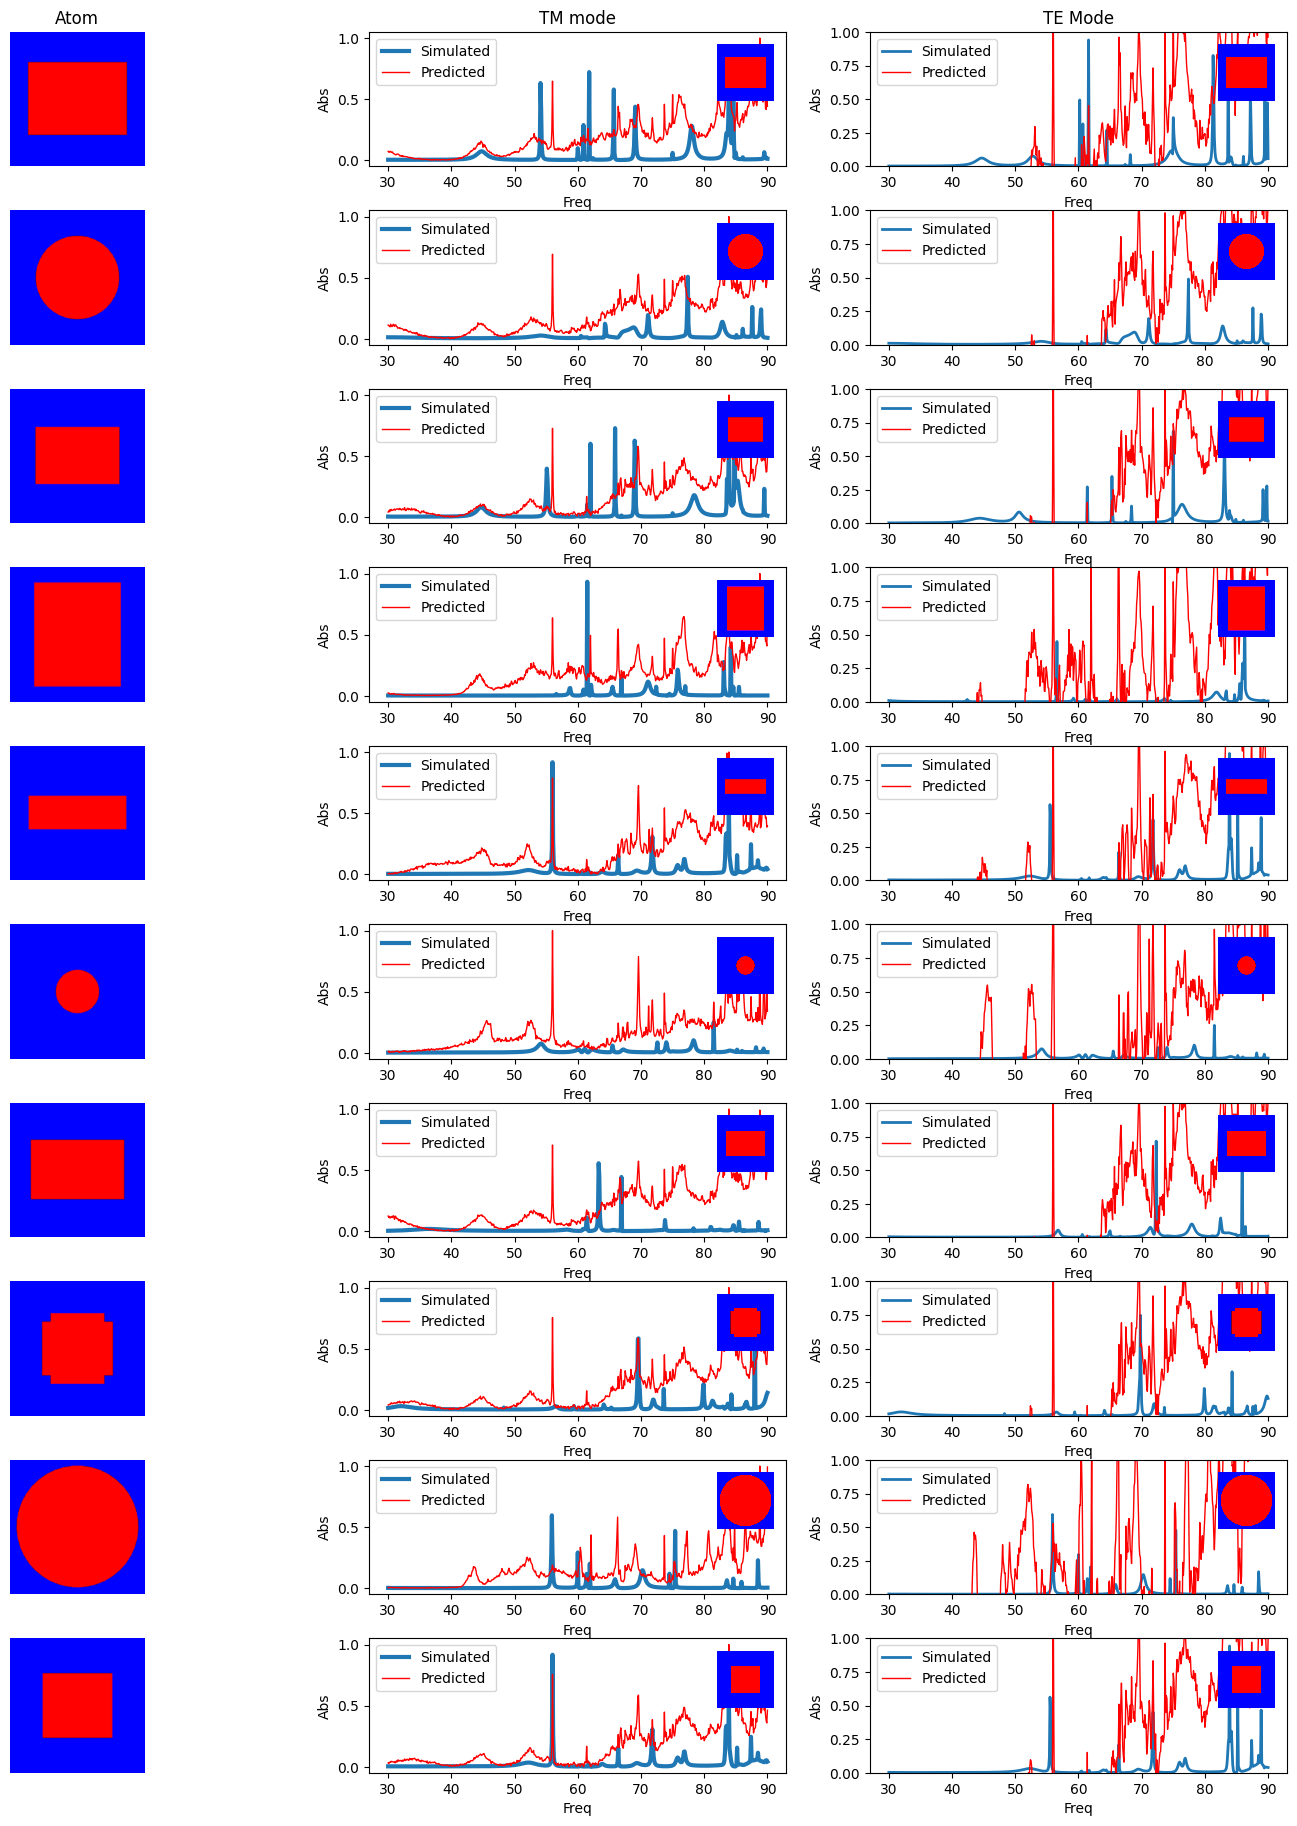

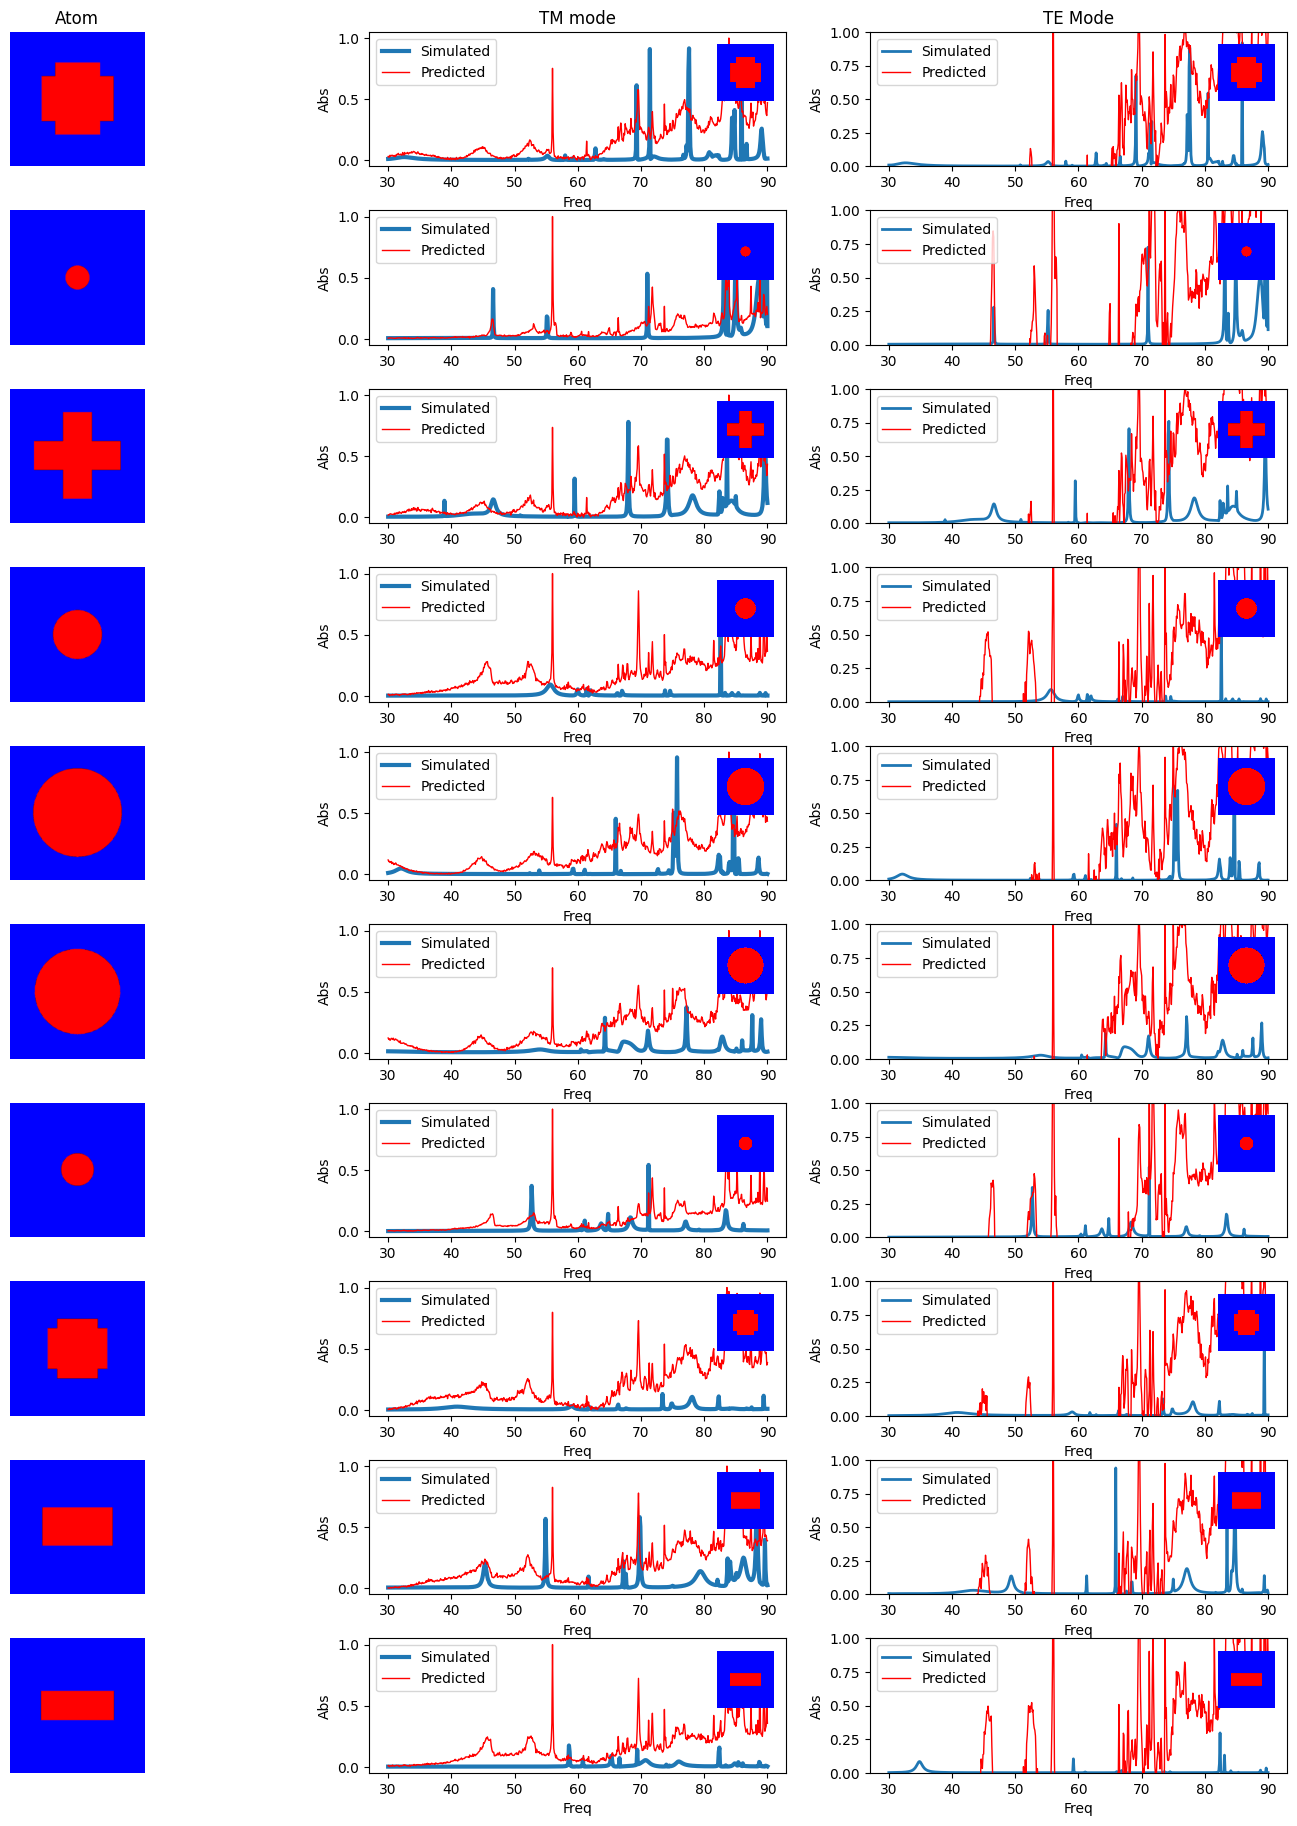

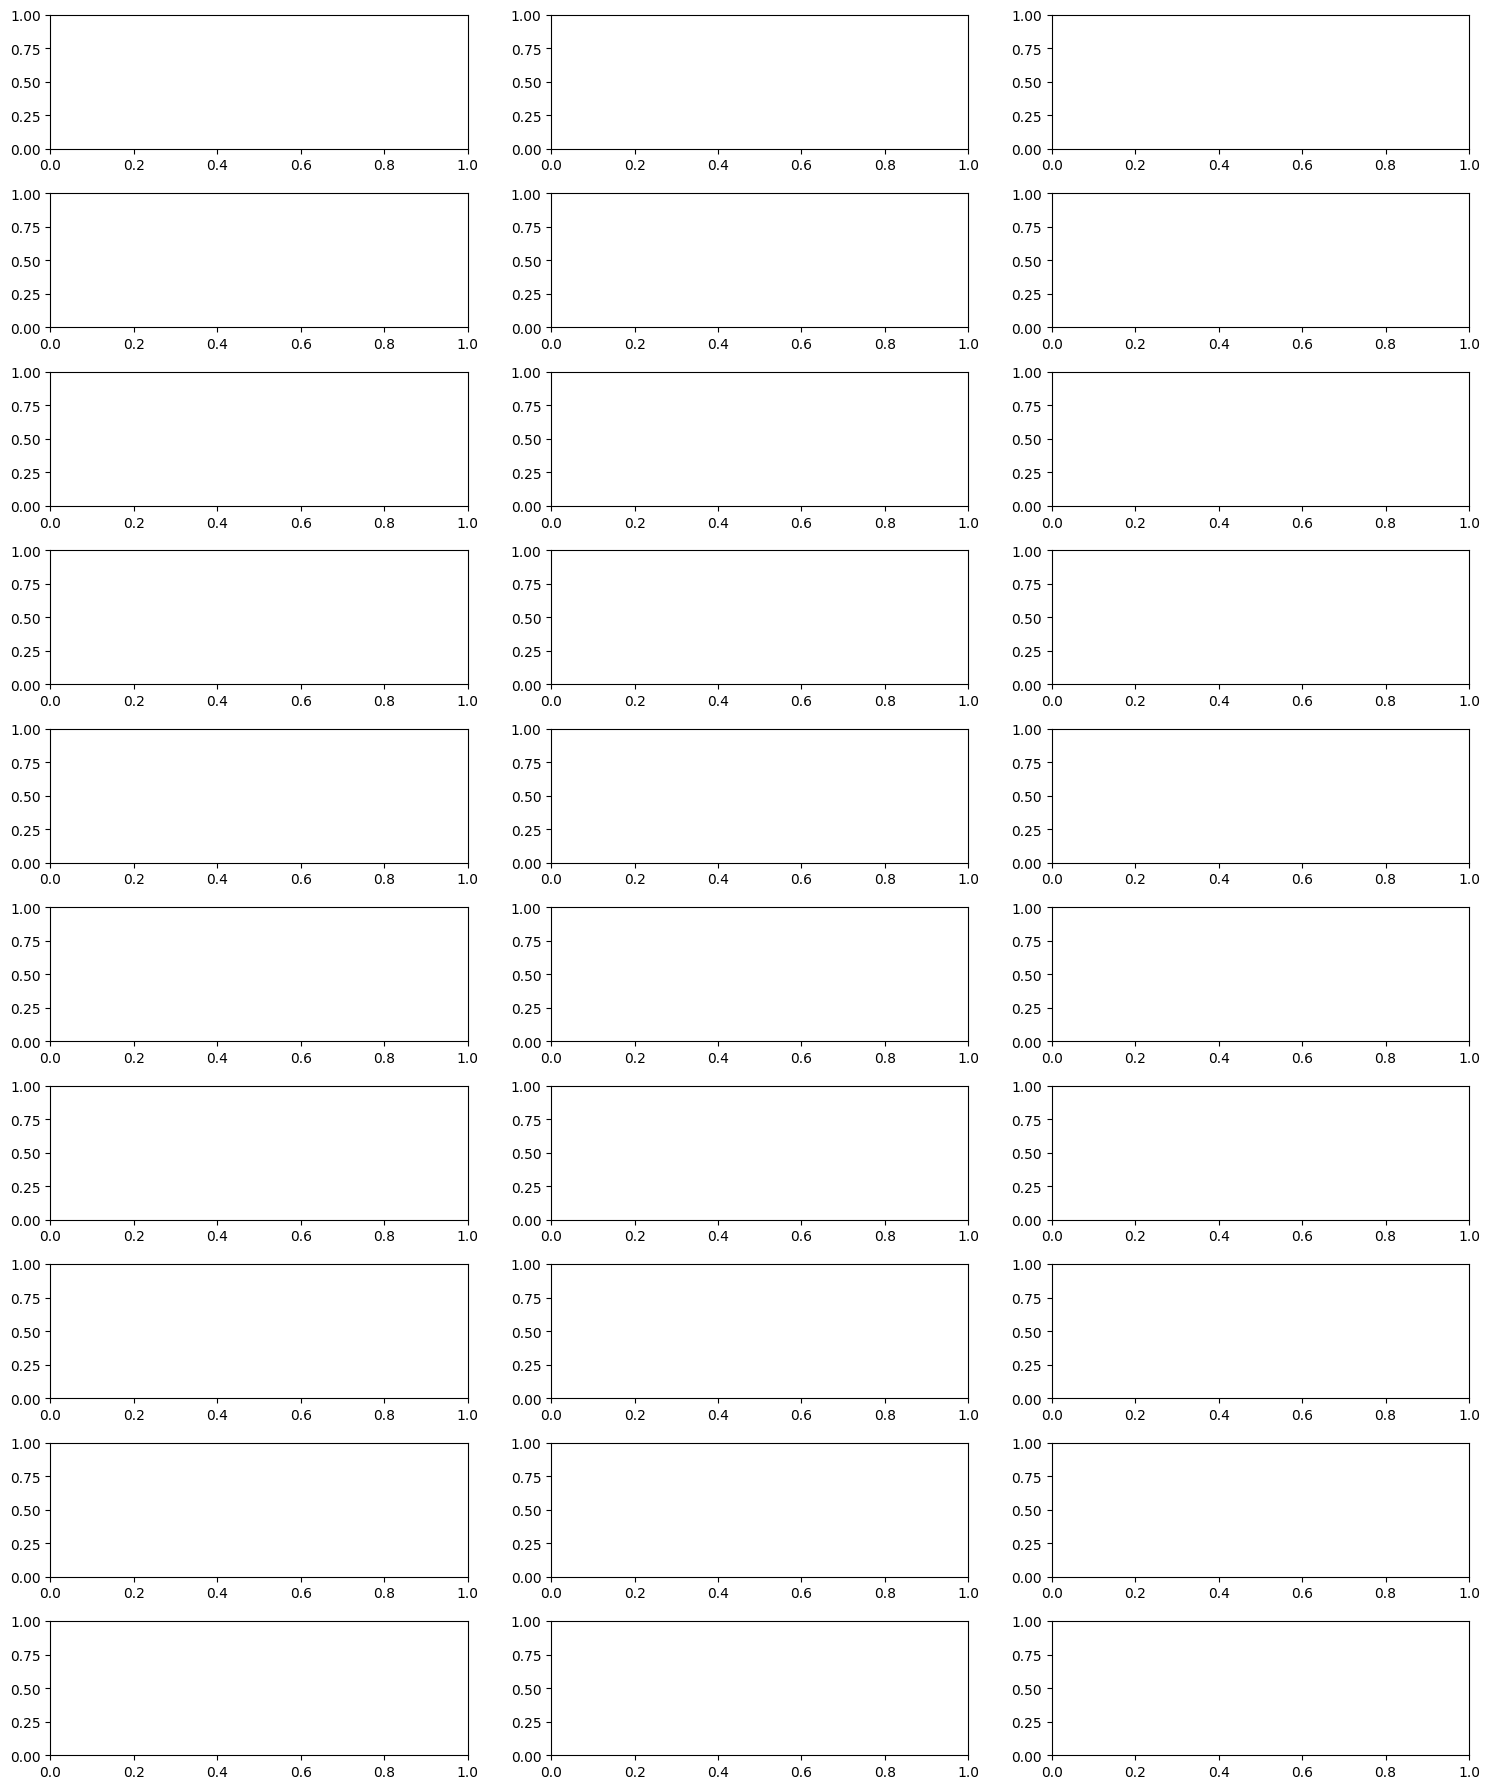

In [18]:

import torch.nn.functional as F

output_test_TM=[]
output_test_TE=[]

for item in iter(dataloader_test):
    inputs,target,path, categories = item
    train=[]
    counter=0

    #figs
    fig, axs = plt.subplots(len(inputs),3,figsize=(15,18))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)

    #loop over test images names
    for name in path:
        series=name.split('_')[-1].split('.')[0]
        batch=name.split('_')[4]
        metricData=[]
        #loop over metric type -TM or TE
        for metric in metricType:
            
            #selecting data files depending on metric
            for name in glob(DataPath+batch+'\\files\\'+'/'+metric+'*'+series+'.csv'): 
                #loading the absorption data
                metricData.append(pd.read_csv(name))
        
        #every image data in array
        train.append(metricData)
    print(metricData)    

    conditioningArray=torch.FloatTensor(set_conditioning(target, path, categories))
    
    #Normalization
    #outmap_min, _ = torch.min(conditioningArray, dim=1, keepdim=True)
    #outmap_max, _ = torch.max(conditioningArray, dim=1, keepdim=True)
    #conditioningTensor = (conditioningArray - outmap_min) / (outmap_max - outmap_min)
    
    #batch size
    output_test_TM=net_TM(x=inputs,condition=conditioningArray)
    output_test_TM= (F.softmax (output_test_TM,dim=1))
    
    output_test_TE=net_TE(x=inputs,condition=conditioningArray)
    #output_test_TE= (F.softmax(output_test_TE,dim=1))

    output_to_plot_TM=output_test_TM.cpu().detach().numpy()
    output_to_plot_TE=output_test_TE.cpu().detach().numpy()

    images_to_plot = inputs.detach().cpu().permute(0, 2, 3,1).numpy()
    
    cols=['Atom','TM mode', 'TE Mode']
    for ax, col in zip(axs[0], cols):
        ax.set_title(col)

    
    #looop over every image data
    #[[freq TM][Freq TE]]
    for i,data in enumerate(train):
        
        x=np.array(data[0].values.T)[0] #frequency values
        
        #predicted TM and TE values 
        toPlot_TM=output_to_plot_TM[i]
        toPlot_TE=output_to_plot_TE[i]
        
        #toPlot_TM=np.exp(toPlot_TM)/sum(np.exp(toPlot_TM))
        toPlot_TM=(toPlot_TM-toPlot_TM.min())/(toPlot_TM.max()-toPlot_TM.min())
        #toPlot_TE=(toPlot_TE-toPlot_TE.min())/(toPlot_TE.max()-toPlot_TE.min())
        
        trueTM=np.array(data[0].values.T)[1]
        trueTE=np.array(data[1].values.T)[1]
        
        
        #scaler = MinMaxScaler(feature_range=(0, trueTM.max()))
        #toPlot_TM = scaler.fit_transform(toPlot_TM.reshape(-1, 1)).flatten()
        #indices = toPlot_TM < 0.1
        #toPlot_TM[indices]=0

        #scaler = MinMaxScaler(feature_range=(0, trueTE.max()))
        #toPlot_TE = scaler.fit_transform(toPlot_TE.reshape(-1, 1)).flatten()
        #indices = toPlot_TE < 0.001
        #toPlot_TE[indices]=0
        
        images = (images_to_plot[i] * 255).round().astype("uint8")
        pil_images = images

        axs[counter][0].imshow(pil_images)
        axs[counter][0].set_axis_off()
        
        axs[counter][1].plot(x,trueTM,label="Simulated",linewidth=3)
        axs[counter][1].plot(x,toPlot_TM,'r-',label="Predicted",linewidth=1)
        axs[counter][1].legend(loc="upper left")
        axs[counter, 1].set(xlabel='Freq', ylabel='Abs')
        #axs[counter, 1].set_ylim([0, 1])

        axs[counter][2].plot(x,trueTE,label="Simulated",linewidth=2)
        axs[counter][2].plot(x,toPlot_TE,'r-',label="Predicted",linewidth=1)
        axs[counter][2].legend(loc="upper left")
        axs[counter, 2].set(xlabel='Freq', ylabel='Abs')
        axs[counter, 2].set_ylim([0, 1])
        
       
        imagebox = OffsetImage(images, zoom=1*0.08)
        imagebox2 = OffsetImage(images, zoom=1*0.08)

        ab = AnchoredOffsetbox(loc=1, child=imagebox, frameon=False)
        ab2 = AnchoredOffsetbox(loc=1, child=imagebox2, frameon=False)

        axs[counter][1].add_artist(ab)
        axs[counter][2].add_artist(ab2)
        
        counter=counter+1

  